In [204]:
import geopandas as gpd
import pandas as pd
from gerrychain import Graph
import random
import networkx as nx
import numpy as np
#from gerrychain import Graph, Partition, Election
#from gerrychain.updaters import Tally, cut_edges


# vtd['vote_difference'] = vtd.EL16G_GV_R - vtd.EL16G_GV_D
# vtd.plot("vote_difference", legend = True, figsize = (20,20) )
# vtd_county.plot("EL12G_GV_R", legend = True, figsize = (10,10) )
#vtd_county = vtd.dissolve(by='County', aggfunc='sum')
#vtd_county.to_file("./data/NC_county_merged.json", driver="GeoJSON")  

In [205]:
np.nan

nan

# Load and Process Data

In [39]:
vtd = gpd.read_file("./data/NC_VTD.shp").to_crs("EPSG:4269")
bg = gpd.read_file("./data/tl_2016_37_bg.shp").to_crs("EPSG:4269")
blocks = gpd.read_file("./data/blocks/tl_2016_37_tabblock10.shp").to_crs("EPSG:4269")

## Join VTDs and Blocks

In [40]:
#joined_within = gpd.sjoin(blocks, vtd, how = 'left', predicate = 'within' )
#joined_within[["GEOID10", "VTD"]].groupby("GEOID10").agg('count').value_counts()

i = 0 # only change to 1 to experiment with block groups;
geo_table = [ blocks, bg][i]
geo_id = ["GEOID10", "GEOID"][i]

joined = gpd.sjoin(geo_table, vtd, how = 'left',  predicate = 'intersects' )
mapping = joined[[geo_id, "VTD"]]

### Checking number of intersections:

In [41]:
display(joined[[geo_id, "VTD"]].groupby(geo_id).agg('count').value_counts())
#counts = joined[[geo_id, "VTD"]].groupby(geo_id).agg('count').rename(columns = {"VTD" : "NUM INTERSECTIONS"})
#m = joined.merge(counts, left_on = geo_id, right_index = True)
#m[m["NUM INTERSECTIONS"] <= 5].plot("NUM INTERSECTIONS", legend = True)

VTD
1      201318
2       73931
3       12086
4        1524
5         112
6          13
7           3
dtype: int64

In [59]:
temp = joined[[geo_id, "VTD"]].groupby(geo_id).agg('count').value_counts()
temp.iloc[0] / temp.sum()

0.6966334125756521

## Compute Area Ratios

In [61]:
# Intersect geos with VTDs, compute area ratios
geo_table_with_map = geo_table.merge(mapping)#.merge(vtd[["VTD", "geometry"]], suffixes = ('_block', '_vt') )
geo_with_vtd = geo_table_with_map.merge(vtd,
                                                      left_on = "VTD", right_on = "VTD",
                                                      suffixes = ('_geo', '_vtd'))

geo_geos = gpd.GeoSeries(geo_with_vtd.geometry_geo).to_crs("ESRI:103500")
geo_with_vtd['geo_intersect'] = geo_geos.intersection(gpd.GeoSeries(geo_with_vtd.geometry_vtd).to_crs("ESRI:103500"))
geo_with_vtd['geo_area'] = geo_geos.area
geo_with_vtd['intersect_area'] = gpd.GeoSeries(geo_with_vtd.geo_intersect).to_crs("ESRI:103500").area
geo_with_vtd['area_proportion'] =  geo_with_vtd['intersect_area'] / geo_with_vtd['geo_area']

In [132]:
#geo_with_vtd.head(5)

Confirming that the isspue of multiple intersections is mostly to do with small intersections. Would be good to understand it but not necessary.

In [62]:
geo_with_vtd[geo_with_vtd.area_proportion >= .2][[geo_id, "VTD"]].groupby(geo_id).agg('count').value_counts()

VTD
1      288215
2         772
dtype: int64

In [67]:
temp = geo_with_vtd[geo_with_vtd.area_proportion >= .05][[geo_id, "VTD"]].groupby(geo_id).agg('count').value_counts()
temp.iloc[0] / temp.sum()

0.9911829943907512

## Adding in block level population

In [148]:
pops = pd.read_csv('./data/us2016_block_pops.csv')
pops['block_fips'] = pops.block_fips.astype("str")
vote_fields = ["EL16G_GV_R" , "EL16G_GV_D", "TOTPOP"]
fields = ['VTD', "GEOID10", 'geometry', 'area_proportion' ] +  vote_fields
geos_simple = geo_with_vtd.rename(columns = {"geometry_geo" : "geometry" })[fields]
geo_with_pop = geos_simple.merge(pops, left_on = geo_id, right_on = 'block_fips',)

In [149]:
# VTD level sums -- doing because the VTD tot pop is generally not equal to the sum of the block pops in it
# This indicates some data level issue , probably in addition to the non exact containment issue.
# Code to check:
# merged = geo_with_pop[["TOTPOP", "VTD"]].merge(geo_with_pop[["pop2016", "VTD"]].groupby("VTD").agg(sum).reset_index(), left_on = "VTD", right_on = "VTD")
# (merged.TOTPOP / merged.pop2016).sort_values().apply(lambda x : round(x,1) ).value_counts()
# But ignoring for now.
vtds_block_pops = geo_with_pop[["pop2016", "VTD"]].groupby("VTD").agg(sum)
vtds_block_pops.columns = ["pop2016_VTD_total"]
geo_with_pop = geo_with_pop.merge(vtds_block_pops, left_on = "VTD", right_index = True)
geo_with_pop['pop_proportion'] = geo_with_pop.pop2016 /  geo_with_pop.pop2016_VTD_total

# Filter out and set to zero for the ones where the intersectiokn is too small
# NB: I did not include this step the first itme running it; TODO -- rerun.


In [150]:
#geo_with_pop.area_proportion

In [151]:
#geo_with_pop['pop_proportion']  = geo_with_pop['pop_proportion']  * (geo_with_pop.area_proportion >= .2).astype(int)

In [152]:
vote_fields = ["EL16G_GV_R" , "EL16G_GV_D", "TOTPOP"]
for field in vote_fields:
    # Eventually replace with ecological inference or something
    geo_with_pop[field + "_block"] = geo_with_pop['pop_proportion'] * geo_with_pop[field]

In [153]:
#geo_with_pop = geo_with_pop
#gpd.GeoDataFrame(geo_with_pop).plot(field + "_block", legend = True, figsize = (10,10) )

### Deduping : For each block, keep only the vote apportionment from the largest VTD.

In [154]:
gdf_dedupped = geo_with_pop.sort_values('area_proportion').drop_duplicates('GEOID10', keep='last')


In [155]:
gdf_subset.pop2016.sum() / geo_with_pop.pop2016.sum()

0.6278388760008075

Dang that was a lot of dupes


In [156]:
# sanity checking
len(gdf_subset.GEOID10.unique()) / len(geo_with_pop.GEOID10.unique())

1.0

### Save  the work so far:

In [280]:
#geo_with_pop.to_csv("geo_with_pop.csv")
#.drop(columns = ["geometry_geo", "geometry_vtd", "geo_intersect"]

In [159]:
gdf_subset = gdf_dedupped[['VTD', "GEOID10", 'geometry', "TOTPOP", "pop2016", "pop_proportion", 'area_proportion' ] +  [ x + "_block" for x in vote_fields] ]
gdf_subset = gpd.GeoDataFrame(gdf_subset)

In [121]:
test = gpd.GeoDataFrame(gdf_subset, geometry="geometry", crs= "ESRI:103500")#.head(10)
test.to_file('./processed_data_outputs/blocks_with_votes.shp')

C:\Users\lnajt\AppData\Local\Temp\ipykernel_24728\2894013665.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  test.to_file('./processed_data_outputs/export.shp')


In [295]:
test_in = gpd.read_file('./processed_data_outputs/blocks_with_votes.shp')

# Building our own VTDs 

SEe VTD properties notebook for info on properties of VTDs

### Simple metamander strategy:

Attempt here is to try to force packing, by building VTDs in the democratic leaning areas that have many adjacencies. (Triangles) and that are square like away.

Alternatively, can we make slightly larger VTDs in democratic areas?

One way to accomplish this; MCMC over 

In [127]:
gdf_subset= gpd.GeoDataFrame(gdf_subset)

<AxesSubplot: >

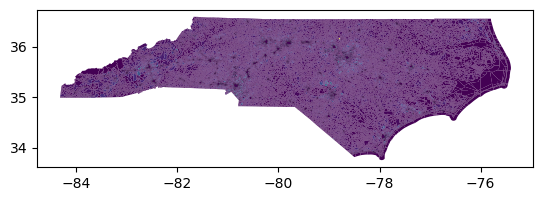

In [128]:
gdf_subset.plot("pop2016")

# Metamanering VTDs by packing

## Make Graph

In [160]:
gdf_subset['pos'] = gdf_subset.centroid

C:\Users\lnajt\AppData\Local\Temp\ipykernel_24728\522360522.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_subset['pos'] = gdf_subset.centroid


In [161]:
gdf_subset = gdf_subset.rename(columns = { "EL16G_GV_D_block" : "dem", "EL16G_GV_R_block" : "rep"})

In [164]:
gdf_subset['dem_prop'] = gdf_subset.dem / gdf_subset.TOTPOP_block
gdf_subset['rep_prop'] = gdf_subset.rep / gdf_subset.TOTPOP_block


### Saving the gdf

In [184]:
gpd.GeoDataFrame(gdf_subset.drop(columns = ["pos"]), geometry = "geometry",
                 crs= "ESRI:103500").to_file('./processed_data_outputs/blocks_df.geojson', driver='GeoJSON')  

### Making and  saving the graph

In [167]:
blocks_graph = Graph.from_geodataframe(gdf_subset, ignore_errors=True)#

C:\Users\lnajt\anaconda3\envs\gerry\lib\site-packages\gerrychain\graph\adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)
C:\Users\lnajt\anaconda3\envs\gerry\lib\site-packages\gerrychain\graph\graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
C:\Users\lnajt\anaconda3\envs\gerry\lib\site-packages\gerrychain\graph\graph.py:272: UserWarning: NA values found in column dem_prop!
  warnings.warn("NA values found in column {}!".format(column))
C:\Users\lnajt\anaconda3\envs\gerry\lib\site-packages\gerrychain\graph\graph.py:272: UserWarning: NA values found in column rep_prop!
  warnings.warn("NA values found in column {}!".format(column))


In [168]:
blocks_graph.nodes[71710]

{'boundary_node': True,
 'boundary_perim': 0.0006337105017212873,
 'area': 1.1672849999990542e-07,
 'VTD': '3716905',
 'GEOID10': '371690703002006',
 'geometry': <shapely.geometry.polygon.Polygon at 0x2abb2d6aec0>,
 'TOTPOP': 1067,
 'pop2016': 0,
 'pop_proportion': 0.0,
 'area_proportion': 0.23375256474219527,
 'rep': 0.0,
 'dem': 0.0,
 'TOTPOP_block': 0.0,
 'pos': <shapely.geometry.point.Point at 0x2ae9da2ae00>,
 'dem_prop': nan,
 'rep_prop': nan}

In [169]:
blocks_graph.to_json('./processed_data_outputs/blocks_graph.json', include_geometries_as_geojson=True)

In [176]:
blocks_graph_test = Graph.from_json('./processed_data_outputs/blocks_graph.json')

In [211]:
def agglomerate(graph, ag_field = "dem_prop", agg_field_threshold = .5,  pop_cap = 6000, steps = 1000000):
    # go through map, agglomerate VTDs that have similar EL16G_GV_D_block proportions, until pop_cap is reached
    # also allow merging of zero pop blocks with no condition.
    for i in range(steps):
        
        e = random.choice(list(graph.edges()))
        
        if  (graph.nodes[e[0]]['TOTPOP_block'] == 0 or
             graph.nodes[e[1]]['TOTPOP_block'] == 0 or
             (graph.nodes[e[0]][ag_field] >  agg_field_threshold and 
            graph.nodes[e[1]][ag_field] >  agg_field_threshold)):
            tot_pop = graph.nodes[e[0]]['TOTPOP_block'] + graph.nodes[e[1]]['TOTPOP_block']
            tot_dem = graph.nodes[e[0]]['dem']+ graph.nodes[e[1]]['dem']
            tot_rep = graph.nodes[e[0]]['rep'] + graph.nodes[e[1]]['rep']
            if tot_pop < pop_cap:
                print("contract")
                for x in ['dem_prop', "rep_prop", "TOTPOP_block", "rep", "dem"]:
                    print("0 has ", x, " as ", blocks_graph.nodes[e[0]][x])
                    print("1 has ", x, " as ", blocks_graph.nodes[e[1]][x])
                nx.contracted_nodes(graph, e[0], e[1], copy = False, self_loops = False)
                # according to documentation node named e[0] remains

                graph.nodes[e[0]]['TOTPOP_block'] = tot_pop
                graph.nodes[e[0]]['dem'] = tot_dem
                graph.nodes[e[0]]['rep'] = tot_rep
                if tot_pop !=0 :
                    
                    graph.nodes[e[0]]['dem_prop'] = tot_dem / tot_pop
                    graph.nodes[e[0]]['rep_prop'] = tot_rep / tot_pop
                else:
                    graph.nodes[e[0]]['dem_prop'] = np.nan
                    graph.nodes[e[0]]['rep_prop'] = np.nan

In [ ]:
agglomerate(graph = blocks_graph_test, steps = 10000)

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.131728559332285
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3605902987782751
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  1.4148553825089851
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.5101831251069656
1 has  rep  as  0.0
0 has  dem  as  0.18637686120143762
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.19776640297812936
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.28664495114006516
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.4756529437804338
0 has  rep  as  0.0
1 has  rep  as  0.1363435148295706
0 has  dem  as  0.0
1 has  dem  as  0.09406817175741479
contract
0 has  dem_prop  as  0.3676085818942961
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.064364207

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.22395508421709295
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.24391765439800375
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  24.33339580209895
0 has  rep  as  0.0
1 has  rep  as  5.935344827586206
0 has  dem  as  0.0
1 has  dem  as  5.449587706146926
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.3812114617337686
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.046789989118607184
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_b

contract
0 has  dem_prop  as  0.4028776978417266
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.022931654676258992
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  1.9336328068395885
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.04434139979713085
1 has  rep  as  0.0
0 has  dem  as  0.7790175336907694
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.14285714285714285
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.361997226074896
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  1.2288027268853856
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.4448231785257776
1 has  rep  as  0.0
0 has  dem  as  0.17554324669791221
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.13252525252525252
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.336969696969697
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  116.06628242074927
1 has  TOTPOP_block  as  0.0
0 has  rep  as  39.11082001571915
1 has  rep  as  0.0
0 has  dem  as  15.381713387477076
1 has  dem  as  0.0
contract
0 has  dem_prop  as  n

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.18494852680156193
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.16577919772807953
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  41.69963665724667
1 has  TOTPOP_block  as  0.0
0 has  rep  as  6.912932310590769
1 has  rep  as  0.0
0 has  dem  as  7.71228636791818
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.5485365853658537
1 has  dem_prop  as  0.5485365853658536
0 has  rep_prop  as  0.03170731707317073
1 has  rep_prop  as  0.03170731707317073
0 has  TOTPOP_b

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.11269001982815598
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.29676140118968936
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  25.603699330972056
1 has  TOTPOP_block  as  0.0
0 has  rep  as  7.5981896890987795
1 has  rep

contract
0 has  dem_prop  as  0.19126284875183555
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.36820851688693096
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  18.59719726913403
1 has  TOTPOP_block  as  0.0
0 has  rep  as  6.847646424721523
1 has  rep  as  0.0
0 has  dem  as  3.5569529284944306
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.12183637433784579
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.30576809888169515
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  107.54048499794493
1 has  TOTPOP_block  as  0.0
0 has  rep  as  32.88244965063708
1 has  rep  as  0.0
0 has  dem  as  13.102342786683108
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2842295526434704
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.07591504744690465
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.6545400769003253
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.049689440993788817
1 has  rep  as  0.0
0 has  dem  as  0.18603963324460218
1 has  dem  as  0.0
contract
0 has  dem_prop  as 

contract
0 has  dem_prop  as  0.587719298245614
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.12231968810916179
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  4.136501079913607
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.5059755219582434
1 has  rep  as  0.0
0 has  dem  as  2.4311015118790498
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2717824601366743
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2841685649202733
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.7591051550848373
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.21571382254403976
1 has  rep  as  0.0
0 has  dem  as  0.20631146655138874
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.17655282604353903
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2911923307369682
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  5.566867852604829
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.6210292249047014
1 has  rep  as  0.0
0 has  dem  as  0.9828462515883101
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan

contract
0 has  dem_prop  as  0.13172855933228497
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3605902987782751
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  16.27083689885333
1 has  TOTPOP_block  as  0.0
0 has  rep  as  5.867105938730105
1 has  rep  as  0.0
0 has  dem  as  2.1433339038165324
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2896890343698854
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3265139116202946
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  9.986236559139787
1 has  TOTPOP_block  as  0.0
0 has  rep  as  3.260645161290323
1 has  rep  as  0.0
0 has  dem  as  2.8929032258064518
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.22905909351692483
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2878657487091222
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  25.020530796194294
1 has  TOTPOP_block  as  0.0
0 has  rep  as  7.20255383074612
1 has  rep  as  0.0
0 has  dem  as  5.731180103488566
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.1993670

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.21656333038086803
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2130203720106289
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  7.723618949888832
0 has  rep  as  0.0
1 has  rep  as  1.6452881819736618
0 has  dem  as  0.0
1 has  dem  as  1.672652642380708
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.3088607594936709
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.35420023014959723
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  39.69522240527183
0 has  rep  as  0.0
1 has  rep  as  14.060056911786731
0 has  dem  as  0.0
1 has  dem  as  12.26029654036244
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.2215941751293351
0 has  rep_prop  as  nan
1 has  rep_p

contract
0 has  dem_prop  as  0.14420131291028446
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.27045951859956235
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  65.5605800717293
1 has  TOTPOP_block  as  0.0
0 has  rep  as  17.73148292530797
1 has  rep  as  0.0
0 has  dem  as  9.453921721503196
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.3725284949988369
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2882065596650384
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  191.11975548763547
1 has  TOTPOP_block  as  0.0
0 has  rep  as  55.08196721311476
1 has  rep  as  0.0
0 has  dem  as  71.19755487635454
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.23400191021967526
0 has  rep_prop  as  nan
1 has  rep_pr

contract
0 has  dem_prop  as  0.2244094488188976
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3366141732283464
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  11.926505614154475
1 has  TOTPOP_block  as  0.0
0 has  rep  as  4.014630826811841
1 has  rep  as  0.0
0 has  dem  as  2.676420551207894
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.21309934189909116
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.28643058602319016
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  2.4155942467827405
0 has  rep  as  0.0
1 has  rep  as  0.691900075700227
0 has  dem  as  0.0
1 has  dem  as  0.5147615442846328
contract
0 has  dem_prop  as  0.2490736928777275
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.1239193083573

contract
0 has  dem_prop  as  0.5814757878554957
1 has  dem_prop  as  0.5814757878554958
0 has  rep_prop  as  0.018831667947732514
1 has  rep_prop  as  0.018831667947732514
0 has  TOTPOP_block  as  34.11442193087009
1 has  TOTPOP_block  as  25.58581644815256
0 has  rep  as  0.6424314660309893
1 has  rep  as  0.48182359952324194
0 has  dem  as  19.836710369487484
1 has  dem  as  14.877532777115613
contract
0 has  dem_prop  as  0.24504504504504504
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.07387387387387387
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  7.905982905982906
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.584045584045584
1 has  rep  as  0.0
0 has  dem  as  1.9373219373219375
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.15078839273883662
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.36213064793957866
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  30.270556061987236
0 has  rep  as  0.0
1 has  rep  as  10.961896080218779
0 has  de

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.29202343397926994
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.024785939612438038
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  12.950102130142982
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.32098044937262915
1 has  rep  as  0.0
0 has  dem  as  3.781733294426612
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.1625194401244168
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.30093312597200617
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.6562340534104439
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.19748256506208536
1 has  rep  as  0.0
0 has  dem  as  0.10665079095084197
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.4400524848286042
0 has  rep_prop  as  nan
1 ha

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2884440400363967
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.1537761601455869
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  4.098197638284649
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.6302050963331262
1 has  rep  as  0.0
0 has  dem  as  1.1821006836544437
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.5485365853658537
1 has  dem_prop  as  0.5485365853658536
0 has  rep_prop  as  0.03170731707317073
1 has  rep_prop  as  0.03170731707317073
0 has  TOTPOP_block  as  29.444736381152566
1 has  TOTPOP_block  as  25.13575056927658
0 has  rep  as  0.9336135925731301
1 has  rep  as  0.7969872131721842
0 has  dem  as  16.151515151515152
1 has  dem  as  13.787878787878787
contract
0 has  dem_prop  as  0.11

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.29615806805708017
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.038858397365532385
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.4994517543859649
0 has  rep  as  0.0
1 has  rep  as  0.019407894736842107
0 has  dem  as  0.0
1 has  dem  as  0.14791666666666667
contract
0 has  dem_prop  as  0.6244725738396624
1 has  dem_prop  as  0.6244725738396625
0 has  rep_prop  as  0.18565400843881857
1 has  rep_prop  as  0.18565400843881857
0 has  

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.31593220338983047
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.08949152542372882
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.506814797846753
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.04535562936662468
1 has  rep  as  0.0
0 has  dem  as  0.1601191157942962
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.10943168077388149
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3805925030229746
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  7.196891996891997
0 has  rep  as  0.0
1 has  rep  as  2.739083139083139
0 has  dem  as  0.0
1 has  dem  as  0.7875679875679875
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.0939306358381503
0 has  rep_prop  as  nan
1 has  re

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.26666666666666666
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.25393081761006286
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  40.53761950949148
0 has  rep  as  0.0
1 has  rep  as  10.293750866010807
0 has  dem  as  0.0
1 has  dem  as  10.810031869197728
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.184460592509782
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.5013974287311348
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  69.5230198019802
0 has  rep  as  0.0
1 has  rep  as  34.858663366336636
0 has  dem  as  0.0
1 has  dem  as  12.824257425742575
contract
0 has  dem_prop  as  0.11048879837067209
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3477596741344

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.142443729903537
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.15594855305466238
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  79.983781278962
0 has  rep  as  0.0
1 has  rep  as  12.473354958294717
0 has  dem  as  0.0
1 has  dem  as  11.39318813716404
contract
0 has  dem_prop  as  0.11078871010287522
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.16183065154312845
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  61.1040967092008
1 has  TOTPOP_block  as  0.0
0 has  rep  as  9.888515782404298
1 has  rep  as  0.0
0 has  dem  as  6.7696440564137
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.12354651162790699
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.32495847176079734
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  19.22280826799715
0 has  rep  as  0.0
1 has  rep  as  6.246614397719173
0 has  dem  as  0.0
1 has  dem  as  2.3749109052031363
contract
0 has  dem_prop  as  nan
1 has  d

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.24012638230647712
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.19589257503949448
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  46.888888888888886
0 has  rep  as  0.0
1 has  rep  as  9.185185185185185
0 has  dem  as  0.0
1 has  dem  as  11.25925925925926
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.3474358974358975
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.11282051282051282
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  29.276139410187664
0 has  rep  as  0.0
1 has  rep  as  3.302949061662198
0 has  dem  as  0.0
1 has  dem  as  10.171581769436997
contract
0 has  dem_prop  as  0.17552785550750447
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.28694988552531164
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  1.4998092331171309
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.43037008775276614
1 has  rep  as  0.0
0 has  dem  as  0.26325829835940484
1 has  dem  as  0.0
contract
0 has  dem_prop  as  

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.12569351444423185
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.31872967285249665
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  110.0744705882353
0 has  rep  as  0.0
1 has  rep  as  35.084
0 has  dem  as  0.0
1 has  dem  as  13.835647058823529
contract
0 has  dem_prop  as  0.3383823949699914
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.22892254929979994
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  207.1591517259834
1 has  TOTPOP_block  as  0.0
0 has  rep  as  47.42340112389617
1 has  rep  as  0.0
0 has  dem  as  70.0990099009901
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.31276939655172414
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2066271551724138
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  52.55929203539823
1 has  TOTPOP_block  as  0.0
0 has  rep  as  10.860176991150443
1 has  rep  as  0.0
0 has  dem  as  16.438938053097345
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2363488182559087

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.3431446540880503
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.12226415094339621
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  156.55619596541788
0 has  rep  as  0.0
1 has  rep  as  19.14121037463977
0 has  dem  as  0.0
1 has  dem  as  53.72142170989434
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.20414937759336102
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.31867219917012446
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  6.272411798727588
0 has  rep  as  0.0
1 has  rep  as  1.9988432620011567
0 has  dem  as  0.0
1 has  dem  as  1.2805089647194912
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.15507060333761233
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.12477535301

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.24210765387235975
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.21598909834203953
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.1010252563140785
0 has  rep  as  0.0
1 has  rep  as  0.23780945236309078
0 has  dem  as  0.0
1 has  dem  as  0.2665666416604151
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.22479338842975205
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.4049586776859504
0 has  TOTPOP_block  as  0.0
1 has  TOTPO

contract
0 has  dem_prop  as  0.1411830357142857
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.29631696428571425
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  136.9258160237389
1 has  TOTPOP_block  as  0.0
0 has  rep  as  40.573442136498514
1 has  rep  as  0.0
0 has  dem  as  19.33160237388724
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.38069835111542194
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.6530876172001294
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.580954169797145
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.3794139744552968
1 has  rep  as  0.0
0 has  dem  as  0.22116829451540196
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.2650065530799476
0 has  rep_prop  as  nan
1 has  rep

contract
0 has  dem_prop  as  0.14420131291028446
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2704595185995624
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  4.988305005457664
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.3491345704038673
1 has  rep  as  0.0
0 has  dem  as  0.7193201309839389
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.21994884910485932
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2621483375959079
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  4.494252873563219
0 has  rep  as  0.0
1 has  rep  as  1.1781609195402298
0 has  dem  as  0.0
1 has  dem  as  0.9885057471264368
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.154776299879081
0 has  rep_prop  as  nan
1 has  rep_

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.6189683860232945
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.0370216306156406
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  4.251857092324019
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.15741068270251152
1 has  rep  as  0.0
0 has  dem  as  2.631765122037496
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.15990818668706963
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.35730680948737564
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  100.23117532647957


contract
0 has  dem_prop  as  0.16289926289926293
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.16683046683046684
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  2.4573584905660377
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.40996226415094345
1 has  rep  as  0.0
0 has  dem  as  0.4003018867924529
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.5093497069494837
1 has  dem_prop  as  0.5093497069494837
0 has  rep_prop  as  0.05749372034607871
1 has  rep_prop  as  0.057493720346078706
0 has  TOTPOP_block  as  9.313090737240076
1 has  TOTPOP_block  as  9.73641304347826
0 has  rep  as  0.5354442344045369
1 has  rep  as  0.5597826086956521
0 has  dem  as  4.743620037807183
1 has  dem  as  4.959239130434782
contract
0 has  dem_prop  as  0.21872659176029963
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.12958801498127342
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.4179711959924859
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.05416405760801503
1 has  rep  as  0.0
0 has  dem

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.17672648178357803
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2914627514953779
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.4137232845894263
0 has  rep  as  0.0
1 has  rep  as  0.12058492688413948
0 has  dem  as  0.0
1 has  dem  as  0.07311586051743532
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1490982981965964
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.4064008128016256
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  167.5923520923521
0 has  rep  as  0.0
1 has  rep  as  68.1096681096681
0 has  dem  as  0.0
1 has  dem  as  24.98773448773449
contract
0 has  dem_prop  as  0.1131813125695217
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3759733036707453
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  15.355022366815778
1 has  TOTPOP_block  as  0.0
0 has  rep  as  5.773078487189914
1 has  rep  as  0.0
0 has  dem  as  1.7379015860105733
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.16289926289926293
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.16683046683046684
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.6143396226415094
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.10249056603773586
1 has  rep  as  0.0
0 has  dem  as  0.10007547169811322
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.11338057523968322
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3843268028345144
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  49.66210350584307
0 has  rep  as  0.0
1 has  rep  as  19.086477462437397
0 has  dem  as  0.0
1 has  dem  as  5.6307178631051755
contract
0 has  dem_prop  as  0.20633523977122745
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3545974

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.15616552297775005
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.29694323144104806
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  193.56664924202823
1 has  TOTPOP_block  as  0.0
0 has  rep  as  57.478306325143755
1 has  rep  as  0.0
0 has  dem  as  30.228437009932044
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.13143658585453816
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.34301743137647767
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  9.224290429042904
0 has  rep  as  0.0
1 has  rep  as  3.164092409240924
0 has  dem  as  0.0
1 has  dem  as  1.2124092409240923
contract
0 has  dem_prop  as  0.065385807251317
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.15835140997

contract
0 has  dem_prop  as  0.42297174111212393
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.13309024612579762
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  3.9746376811594204
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.5289855072463768
1 has  rep  as  0.0
0 has  dem  as  1.681159420289855
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.6172035640849898
1 has  dem_prop  as  0.6172035640849897
0 has  rep_prop  as  0.07779300891021247
1 has  rep_prop  as  0.07779300891021247
0 has  TOTPOP_block  as  23.41604938271605
1 has  TOTPOP_block  as  4.503086419753086
0 has  rep  as  1.821604938271605
1 has  rep  as  0.35030864197530864
0 has  dem  as  14.45246913580247
1 has  dem  as  2.779320987654321
contract
0 has  dem_prop  as  nan
1

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.10216168196624222
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.24844536570920933
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.6611198120595145
0 has  rep  as  0.0
1 has  rep  as  0.16425215348472982
0 has  dem  as  0.0
1 has  dem  as  0.06754111198120595
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.24457282913165265
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2426470588235294
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  3.102324570932001
0 has  rep  as  0.0
1 has  rep  as  0.7527699326526179
0 has  dem  as  0.0
1 has  dem  as  0.7587442971974799
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.20292573143285822
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2066766691672918
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  56.90023980815348
0 has  rep  as  0.0
1 has  rep  as  11.759952038369304
0 has  dem  as  0.0
1 has  dem  as  11.54652278177458
contract
0 has  dem_prop  as  0

contract
0 has  dem_prop  as  0.2528814221527642
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2510255909357297
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  192.65909797822707
1 has  TOTPOP_block  as  0.0
0 has  rep  as  48.36236391912909
1 has  rep  as  0.0
0 has  dem  as  48.719906687402805
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.20797011207970112
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2772934827729348
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  374.557339005995
1 has  TOTPOP_block  as  0.0
0 has  rep  as  103.86230903113518
1 has  rep  as  0.0
0 has  dem  as  77.89673177335139
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.1833766233766234
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2238961038961039
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  33.51188483428189
1 has  TOTPOP_block  as  0.0
0 has  rep  as  7.503180448610646
1 has  rep  as  0.0
0 has  dem  as  6.1452962838968865
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.1190864

contract
0 has  dem_prop  as  0.17038690476190477
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.42038690476190477
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  135.76331360946745
1 has  TOTPOP_block  as  0.0
0 has  rep  as  57.0731191885038
1 has  rep  as  0.0
0 has  dem  as  23.132290786136938
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.36543606206527557
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.15741037988229
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  52.381612009535466
1 has  TOTPOP_block  as  0.0
0 has  rep  as  8.245409445267702
1 has  rep  as  0.0
0 has  dem  as  19.142130017395786
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1323529411764706
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.32147742818057456
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  60.321389793702494
0 has  rep  as  0.0
1 has  rep  as  19.391965255157437
0 has  dem  as  0.0
1 has  dem  as  7.9837133550488595
contract
0 has  dem_prop  as  0.2303443794671865
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2706302794022092
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  68.57089319175515
1 has  TOTPOP_block  as  0.0
0 has  rep  as  18.55735998334374
1 has  rep  as  0.0
0 has  dem  as  15.794919841765562
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2578710644677661
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3733133433283

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.23052294557097117
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2678762006403415
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.6607898448519041
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.1770098730606488
1 has  rep  as  0.0
0 has  dem  as  0.15232722143864597
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as 

contract
0 has  dem_prop  as  0.13854351687388988
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2580563308804872
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  3.484912125566486
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.8993036365646071
1 has  rep  as  0.0
0 has  dem  as  0.4828119818724439
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.27046460176991155
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2394911504424779
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  6.372180451127819
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.5260808270676691
1 has  rep  as  0.0
0 has  dem  as  1.7234492481203008
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.1902252036415908
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2362242453282223
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  2.913176996091569
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.6881630374092685
1 has  rep  as  0.0
0 has  dem  as  0.5541596873255165
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.19047619047619047
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.27687074829931974
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  96.22291021671826
0 has  rep  as  0.0
1 has  rep  as  26.641309155241043
0 has  dem  as  0.0
1 has  dem  as  18.328173374613
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.11507156890261017
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.1754139769856862
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  3.7951358068524765
0 has  rep  as  0.0
1 has  rep  as  0.665719865080774
0 has  dem  as  0.0
1 has  dem  as  0.43671223149298777
contract
0 has  dem_prop  as  0.31276939655172414
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.20662715517241378
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.7299901671583088
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.15083579154375615
1 has  rep  as  0.0
0 has  dem  as  0.22831858407079647
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.25553547220967016
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3990058743786715
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  44.827819041188384
0 has  rep  as  0.0
1 has  rep  as  17.88656313301823
0 has  dem  as  0.0
1 has  dem  as  11.455097906819717
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.22883231876037632
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.1184283342556724
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_b

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.10560181680545042
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.4095382286146858
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  39.465560165975106
1 has  TOTPOP_block  as  0.0
0 has  rep  as  16.16265560165975
1 has  rep  as  0.0
0 has  dem  as  4.1676348547717845
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.1997197343569122
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.21811978309876318
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  18.9081483450751
1 has  TOTPOP_block  as  0.0
0 has  rep  as  4.124241215827019
1 has  rep  as  0.0
0 has  dem  as  3.7763303646594886
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2261280167890871
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.20146904512067

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.07460237313809645
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.24867457712698812
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  76.73251729643427
0 has  rep  as  0.0
1 has  rep  as  19.081426290580094
0 has  dem  as  0.0
1 has  dem  as  5.724427887174029
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.2613438045375218
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.21422338568935428
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  29.2895503073439
0 has  rep  as  0.0
1 has  rep  as  6.274506632157878
0 has  dem  as  0.0
1 has  dem  as  7.654642510514396
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.28192473781616284
0 has  rep_prop  as  nan
1 has  rep_p

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.16411286946328393
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2837645482709537
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.7011271574498062
0 has  rep  as  0.0
1 has  rep  as  0.19895503111424212
0 has  dem  as  0.0
1 has  dem  as  0.11506398966772338
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.13423645320197045
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3673029556650246
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.4534064212999218
0 has  rep  as  0.0
1 has  rep  as  0.5338404743259872
0 has  dem  as  0.0
1 has  dem  as  0.19510012305627028
contract
0 has  dem_prop  as  0.134640185710601
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.30177972

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.12640708617826166
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.28787599188042073
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.7340829043619616
0 has  rep  as  0.0
1 has  rep  as  0.21132484421565972
0 has  dem  as  0.0
1 has  dem  as  0.09279328095367109
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.17790387182910547
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.29572763684913217
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.4304129863929338
0 has  rep  as  0.0
1 has  rep  as  0.4230126521842922
0 has  dem  as  0.0
1 has  dem  as  0.2544760085939365
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.08331773076202957
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.14435

contract
0 has  dem_prop  as  0.21420133875836725
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3094894343089644
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  1.508613292851957
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.4668998745957363
1 has  rep  as  0.0
0 has  dem  as  0.32314698699755795
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.29721640227476803
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.34181382819515116
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  7.851938895417156
0 has  rep  as  0.0
1 has  rep  as  2.6839012925969445
0 has  dem  as  0.0
1 has  dem  as  2.333725029377203
contract
0 has  dem_prop  as  0.1069735951252539
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.11442112389

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.25323249573066603
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.1884606001463772
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  18.09365703867191
0 has  rep  as  0.0
1 has  rep  as  3.40994146435083
0 has  dem  as  0.0
1 has  dem  as  4.58190192879762
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.12398246712586099
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.308703819661866
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  4.140657916058986
0 has  rep  as  0.0
1 has  rep  as  1.278236914600551
0 has  dem  as  0.0
1 has  dem  as  0.5133689839572193
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.20618921308576482
0 has  rep_prop  as  nan
1 has  rep_prop

contract
0 has  dem_prop  as  0.274814314652262
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3506076975016881
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.6603500167205439
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.23152379890759112
1 has  rep  as  0.0
0 has  dem  as  0.18147363727566604
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2436218109054527
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.010005002501250625
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  68.38423401090729
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.6841844323252355
1 has  rep  as  0.0
0 has  dem  as  16.659890927119484
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  na

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.20492307692307693
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.10912820512820512
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  6.47219353887004
0 has  rep  as  0.0
1 has  rep  as  0.7062988641392536
0 has  dem  as  0.0
1 has  dem  as  1.3263018144269068
contract
0 has  dem_prop  as  0.12635222847252273
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.27780181739506704
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  22.03631568269426
1 has  TOTPOP_block  as  0.0
0 has  rep  as  6.121728545343883
1 has  rep  as  0.0
0 has  dem  as  2.7843375938324204
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.11636723256963903
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.21839459370364267
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  5.423882503192848
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.1845466155810984
1 has  rep  as  0.0
0 has  dem  as  0.6311621966794381
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.25500812127774775
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.31889550622631296
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.8859768550034035
0 has  rep  as  0.0
1 has  rep  as  0.60142954390742
0 has  dem  as  0.0
1 has  dem  as  0.48093941456773315
contract
0 has  dem_prop  as  0.19773817683344755
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.28992460589444824
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.7691091196626253
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.22298365840801265
1 has  rep  as  0.0
0 has  dem  as  0.15208223510806537
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.0776778413736713
0 has  rep_prop  as  nan
1 has

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2766712984406361
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.28022232515053264
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  66.61074864536106
1 has  TOTPOP_block  as  0.0
0 has  rep  as  18.665818865420768
1 has  rep  as  0.0
0 has  dem  as  18.429282317814884
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.13464018571060096
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.30177972659272634
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  14.888632872503841
1 has  TOTPOP_block  as  0.0
0 has  rep  as  4.493087557603687
1 has  rep  as  0.0
0 has  dem  as  2.0046082949308754
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.13095238095238096
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.42658730158730157
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  40.51934651762683
0 has  rep  as  0.0
1 has  rep  as  17.285038693035254
0 has  dem  as  0.0
1 has  dem  as  5.306104901117799
contract
0 has  dem_prop  as  0.16908212560386474
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3273875882571535
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  55.90720221606648
1 has  TOTPOP_block  as  0.0
0 has  rep  as  18.303324099722992
1 has  rep  as  0.0
0 has  dem  as  9.452908587257618
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.5877192982456141
1 has  dem_prop  as  0.5877192982456141
0 has  rep_prop  as  0.12231968810916179
1 has  rep_prop  as  0.12231968810916179
0 has  TOTPOP_block  as  0.5909287257019438
1 has  TOTPOP_block  as  1.1818574514038875
0 has  rep  as  0.07228221742260618
1 has  rep  as  0.14456443484521236
0 has  dem  as  0.34730021

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.2540894220283533
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.29552889858233367
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.5444210526315791
0 has  rep  as  0.0
1 has  rep  as  0.45642105263157895
0 has  dem  as  0.0
1 has  dem  as  0.39242105263157895
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.10255175734232065
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2961001444390948
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  6.134886773875944
0 has  rep  as  0.0
1 has  rep  as  1.8165408598621595
0 has  dem  as  0.0
1 has  dem  as  0.6291434197571382
contract
0 has  dem_prop  as  0.13697738734341955
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.26712217

contract
0 has  dem_prop  as  0.05622879301987397
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.18831798351914686
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  3.886586284853052
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.7319140919366993
1 has  rep  as  0.0
0 has  dem  as  0.2185380557648832
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.5578284815106216
1 has  dem_prop  as  0.5578284815106216
0 has  rep_prop  as  0.0873328088119591
1 has  rep_prop  as  0.0873328088119591
0 has  TOTPOP_block  as  8.652144315861129
1 has  TOTPOP_block  as  2.1630360789652823
0 has  rep  as  0.7556160653505786
1 has  rep  as  0.18890401633764464
0 has  dem  as  4.826412525527569
1 has  dem  as  1.2066031313818923
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan


contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.19302249755461362
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.44636452559504397
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  3.0785445420326223
0 has  rep  as  0.0
1 has  rep  as  1.3741530740276033
0 has  dem  as  0.0
1 has  dem  as  0.5942283563362609
contract
0 has  dem_prop  as  0.524108488196886
1 has  dem_prop  as  0.5241084881968859
0 has  rep_prop  as  0.08086388749372175
1 has  rep_prop  as  0.08086388749372174
0 has  TOTPOP_block  as  53.26132604631094
1 has  TOTPOP_block  as  30.925931252696678
0 has  rep  as  4.30691787717532
1 has  rep  as  2.5007910254566372
0 has  dem  as  27.914713073493456
1 has  dem  as  16.208543074931683
contract
0 has  dem_prop  as  0.25931558935361215
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.06403041825095057
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  1.3739421168112005
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.08797408839201755
1 has  rep  as  0.0
0 has  dem 

contract
0 has  dem_prop  as  0.08768741481144934
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3314402544298046
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  73.07542403464453
1 has  TOTPOP_block  as  0.0
0 has  rep  as  24.220137134608443
1 has  rep  as  0.0
0 has  dem  as  6.40779501984843
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.09108910891089109
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.4118811881188119
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_blo

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.3213644524236984
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.12387791741472172
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.379281881964507
0 has  rep  as  0.0
1 has  rep  as  0.17086256706562114
0 has  dem  as  0.0
1 has  dem  as  0.4432521667354519
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.06538580725131701
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.15835140997830804
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  2.072131849315068
0 has  rep  as  0.0
1 has  rep  as  0.328125
0 has  dem  as  0.0
1 has  dem  as  0.13548801369863012
contract
0 has  dem_prop  as  0.2562076749435666
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.28893905191873587
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  26.058823529411764
1 has  TOTPOP_block  as  0.0
0 has  rep  as  7.529411764705882
1 has  rep  as  0.0
0 has  dem  as  6.676470588235294
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  d

contract
0 has  dem_prop  as  0.28422955264347044
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.07591504744690465
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  26.836143152913337
1 has  TOTPOP_block  as  0.0
0 has  rep  as  2.0372670807453415
1 has  rep  as  0.0
0 has  dem  as  7.62762496302869
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1453661172656039
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.1599567684409619
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  6.925995236474991
0 has  rep  as  0.0
1 has  rep  as  1.1078598162640354
0 has  dem  as  0.0
1 has  dem  as  1.0068050357264375
contract
0 has  dem_prop  as  0.16411286946328393
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2837645482709537
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  1.4022543148996125
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.39791006222848424
1 has  rep  as  0.0
0 has  dem  as  0.23012797933544676
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.

contract
0 has  dem_prop  as  0.5040650406504065
1 has  dem_prop  as  0.5040650406504065
0 has  rep_prop  as  0.4932249322493225
1 has  rep_prop  as  0.4932249322493225
0 has  TOTPOP_block  as  18.236293436293437
1 has  TOTPOP_block  as  0.8548262548262547
0 has  rep  as  8.994594594594595
1 has  rep  as  0.4216216216216216
0 has  dem  as  9.192277992277992
1 has  dem  as  0.43088803088803085
contract
0 has  dem_prop  as  0.39570552147239263
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.07177914110429448
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  57.142857142857146
1 has  TOTPOP_block  as  0.0
0 has  rep  as  4.1016652059596845
1 has  rep  as  0.0
0 has  dem  as  22.611744084136724
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2842295526434704
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.07591504744690465
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  71.34486838213547
1 has  TOTPOP_block  as  0.0
0 has  rep  as  5.416149068322982
1 has  rep  as  0.0
0 has  dem  as

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1063036180529653
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.37784408802685565
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  12.250296158402437
0 has  rep  as  0.0
1 has  rep  as  4.628701980030462
0 has  dem  as  0.0
1 has  dem  as  1.3022508038585208
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.15928819444444445
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2890625
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  39.02385067404079
1 has  TOT

contract
0 has  dem_prop  as  0.24729294702955812
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2841673983026046
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  21.544298293292748
1 has  TOTPOP_block  as  0.0
0 has  rep  as  6.1221871942602455
1 has  rep  as  0.0
0 has  dem  as  5.327753016632243
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.10643935030526439
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3097569404446493
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  19.328460793804453
0 has  rep  as  0.0
1 has  rep  as  5.9871248789932245
0 has  dem  as  0.0
1 has  dem  as  2.0573088092933207
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.5411906193625977
1 has  dem_prop  as  0.5411906193625976
0 has  rep_prop  as

contract
0 has  dem_prop  as  0.13697738734341958
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2671221734179275
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  22.590036749693752
1 has  TOTPOP_block  as  0.0
0 has  rep  as  6.034299714169049
1 has  rep  as  0.0
0 has  dem  as  3.094324213964884
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.06538580725131701
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.15835140997830802
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  8.97923801369863
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.421875
1 has  rep  as  0.0
0 has  dem  as  0.5871147260273972
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.30587204206836105
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.13409290096406662
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  2.265012406947891
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.3037220843672457
1 has  rep  as  0.0
0 has  dem  as  0.6928039702233251
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem

contract
0 has  dem_prop  as  0.11891460494812452
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.28890662410215484
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  2.2375
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.6464285714285715
1 has  rep  as  0.0
0 has  dem  as  0.26607142857142857
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.34974958263772954
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.19866444073455758
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  20.459203036053133
0 has  rep  as  0.0
1 has  rep  as  4.064516129032258
0 has  dem  as  0.0
1 has  dem  as  7.155597722960152
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TO

contract
0 has  dem_prop  as  0.12582396277626987
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.18689414501744864
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  65.22374193548387
1 has  TOTPOP_block  as  0.0
0 has  rep  as  12.189935483870968
1 has  rep  as  0.0
0 has  dem  as  8.206709677419354
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.14900662251655628
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2549668874172185
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  6.371308016877637
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.6244725738396624
1 has  rep  as  0.0
0 has  dem  as  0.9493670886075949
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1016403988420714
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.24863300096494048
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  30.649758021150745
0 has  rep  as  0.0
1 has  rep  as  7.620541315647966
0 has  dem  as  0.0
1 has  dem  as  3.115253629682739
contract
0 has  dem_prop  as  nan
1

contract
0 has  dem_prop  as  0.5222197157681029
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.1030904579291676
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  50.06533238027163
1 has  TOTPOP_block  as  0.0
0 has  rep  as  5.161258041458185
1 has  rep  as  0.0
0 has  dem  as  26.145103645461045
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.5877192982456141
1 has  dem_prop  as  0.5877192982456141
0 has  rep_prop  as  0.1223196881091618
1 has  rep_prop  as  0.12231968810916179
0 has  TOTPOP_block  as  6.500215982721382
1 has  TOTPOP_block  as  18.9097192224622
0 has  rep  as  0.7951043916486682
1 has  rep  as  2.313030957523398
0 has  dem  as  3.8203023758099355
1 has  dem  as  11.113606911447084
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.18623024830699775
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.20316027088036118
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  54.45862884160756
0 has  rep  as  0.0
1 has  rep  as  11.063829787234042
0 has  dem  as  0.0
1 has  dem  as  10.141843971631205
contract
0 has  dem_prop  as  0.14588235294117646
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.38705882352941173
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  12.00434546442151
1 has  TOTPOP_block  as  0.0
0 has  rep  as  4.646387832699619
1 has  rep  as  0.0
0 has  dem  as  1.7512221618685497
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.13862541952429594
0 has  rep_prop  as  nan
1 has  r

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.12538884900693947
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.34936587700406796
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  122.56221116246
1 has  TOTPOP_block  as  0.0
0 has  rep  as  42.81905439033061
1 has  rep  as  0.0
0 has  dem  as  15.367934589406328
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.1
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2641666666666667
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  21.93298255330933
1 has  TOTPOP_block  as  0.0
0 has  rep  as  5.793962891165882
1 has  rep  as  0.0
0 has  dem  as  2.1932982553309333
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.23666210670314636
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.32649

contract
0 has  dem_prop  as  0.5647753361757953
1 has  dem_prop  as  0.5647753361757953
0 has  rep_prop  as  0.17776320104952445
1 has  rep_prop  as  0.17776320104952442
0 has  TOTPOP_block  as  6.659849086576648
1 has  TOTPOP_block  as  9.68705321683876
0 has  rep  as  1.1838760921366165
1 has  rep  as  1.722001588562351
0 has  dem  as  3.76131850675139
1 has  dem  as  5.471008737092931
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.22395508421709295
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.24391765439800375
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  24.33339580209895
0 has  rep  as  0.0
1 has  rep  as  5.935344827586206
0 has  dem  as  0.0
1 has  dem  as  5.449587706146926
contract
0 has  dem_prop  as  nan
1 has 

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.20960960960960962
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.22222222222222224
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  2.674698795180723
0 has  rep  as  0.0
1 has  rep  as  0.5943775100401607
0 has  dem  as  0.0
1 has  dem  as  0.5606425702811245
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  

contract
0 has  dem_prop  as  0.15953488372093025
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.4274418604651163
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  1.3933895009721322
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.5955930006480882
1 has  rep  as  0.0
0 has  dem  as  0.22229423201555412
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.13997985901309165
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.35448136958710974
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  32.69634146341463
0 has  rep  as  0.0
1 has  rep  as  11.590243902439024
0 has  dem  as  0.0
1 has  dem  as  4.576829268292683
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1234967622571693
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.27705827937095284
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  197.96626506024094
0 has  rep  as  0.0
1 has  rep  as  54.848192771084335
0 has  dem  as  0.0
1 has  dem  as  24.448192771084337
contract
0 has  dem_prop  as  0

contract
0 has  dem_prop  as  0.11648631444939529
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.4143857415658816
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  25.60594439117929
1 has  TOTPOP_block  as  0.0
0 has  rep  as  10.610738255033556
1 has  rep  as  0.0
0 has  dem  as  2.98274209012464
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.18649885583524028
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.23417238749046532
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  10.451998671243494
0 has  rep  as  0.0
1 has  rep  as  2.44756948289226
0 has  dem  as  0.0
1 has  dem  as  1.9492857933783634
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.24066029539530845
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.4265855777584709
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.9626428770560357
0 has  rep  as  0.0
1 has  rep  as  0.4106495678840256
0 has  dem  as  0.0
1 has  dem  as  0.23166991915249513
contract
0 has  dem_prop  as  nan


contract
0 has  dem_prop  as  0.23935091277890466
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.31896551724137934
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  9.099538562953198
1 has  TOTPOP_block  as  0.0
0 has  rep  as  2.9024390243902443
1 has  rep  as  0.0
0 has  dem  as  2.1779828609096903
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.13408723747980614
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3416801292407108
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.4805900621118012
0 has  rep  as  0.0
1 has  rep  as  0.16420807453416147
0 has  dem  as  0.0
1 has  dem  as  0.06444099378881987
contract
0 has  dem_prop  as  0.1533841908781042
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.14575555916247362
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  284.5415971643036
1 has  TOTPOP_block  as  0.0
0 has  rep  as  41.47351959966639
1 has  rep  as  0.0
0 has  dem  as  43.644182652210176
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0

contract
0 has  dem_prop  as  0.06032719836400818
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3210633946830266
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.5433333333333333
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.17444444444444446
1 has  rep  as  0.0
0 has  dem  as  0.03277777777777778
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.12469218715021267
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3024401164092232
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  7.334975369458128
0 has  rep  as  0.0
1 has  rep  as  2.218390804597701
0 has  dem  as  0.0
1 has  dem  as  0.9146141215106732
contract
0 has  dem_prop  as  0.16398501212254793
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2808022922636103
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  35.99044843775295
1 has  TOTPOP_block  as  0.0
0 has  rep  as  10.106200420916302
1 has  rep  as  0.0
0 has  dem  as  5.901894123360854
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.15538379530916846
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.31423240938166314
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  15.03054581872809
1 has  TOTPOP_block  as  0.0
0 has  rep  as  4.72308462694041
1 has  rep  as  0.0
0 has  dem  as  2.3355032548823234
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.2215941751293351
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.4197164207702625
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  290.5009596928983
0 has  rep  as  0.0
1 has  rep  as  121.92802303262955
0 has  dem  as  0.0
1 has  dem  as  64.37332053742801
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 h

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.17379145025968837
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.24011186576108673
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.1555863342566943
0 has  rep  as  0.0
1 has  rep  as  0.2774699

contract
0 has  dem_prop  as  0.21324655436447162
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3372894333843798
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  5.341513292433539
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.801635991820041
1 has  rep  as  0.0
0 has  dem  as  1.1390593047034765
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.22199330414627866
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2956476950811228
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.5319568648079958
0 has  rep  as  0.0
1 has  rep  as  0.45291951604418723
0 has  dem  as  0.0
1 has  dem  as  0.3400841662283009
contract
0 has  dem_prop  as  0.12509419743782968
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3858327053504145
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  23.4821077467558
1 has  TOTPOP_block  as  0.0
0 has  rep  as  9.060165159260716
1 has  rep  as  0.0
0 has  dem  as  2.9374754227290603
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.48384948384948384
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.058941058941058944
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.078082929456112
0 has  rep  as  0.0
1 has  rep  as  0.06354334948842219
0 has  dem  as  0.0
1 has  dem  as  0.5216298689642793
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.18443086671192577
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3421588594704684
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  31.454560503227942
0 has  rep  as  0.0
1 has  rep  as  10.762456546929316
0 has  dem  as  0.0
1 has  dem  as  5.8011918556530375
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.44141252006420545
0 has  rep_prop  as  nan
1 has

contract
0 has  dem_prop  as  0.2828341013824885
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.33410138248847926
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  74.98305084745763
1 has  TOTPOP_block  as  0.0
0 has  rep  as  25.05194095133953
1 has  rep  as  0.0
0 has  dem  as  21.20776380535812
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.3083542488347078
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.30225887414844027
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  118.38451935081149
1 has  TOTPOP_block  as  0.0
0 has  rep  as  35.78277153558052
1 has  rep  as  0.0
0 has  dem  as  36.504369538077405
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.17934347477982387
0 has  rep_prop  as  nan
1 has  rep_

contract
0 has  dem_prop  as  0.28192473781616284
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.23504009870450338
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  9.829206670035372
1 has  TOTPOP_block  as  0.0
0 has  rep  as  2.310257705912077
1 has  rep  as  0.0
0 has  dem  as  2.771096513390601
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.23562570462232243
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.24718151071025932
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  83.54132328702613
1

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.6244725738396625
1 has  dem_prop  as  0.6244725738396625
0 has  rep_prop  as  0.18565400843881855
1 has  rep_prop  as  0.18565400843881857
0 has  TOTPOP_block  as  2.679130434782609
1 has  TOTPOP_block  as  2.143304347826087
0 has  rep  as  0.4973913043478261
1 has  rep  as  0.3979130434782609
0 has  dem  as  1.6730434782608696
1 has  dem  as  1.3384347826086958
contract
0 has  dem_prop  as  0.144116122343183
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.30171073094867806
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  13.762842465753424
1 has  TOTPOP_block  as  0.0
0 has  rep  as  4.152397260273973
1 has  rep  as  0.0
0 has  dem  as  1.9834474885844748
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1

contract
0 has  dem_prop  as  0.420081044574516
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.19180549302116165
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  546.4618705035971
1 has  TOTPOP_block  as  0.0
0 has  rep  as  104.81438848920862
1 has  rep  as  0.0
0 has  dem  as  229.55827338129495
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.141846921797005
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.17678868552412647
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  3.7254815142793887
0 has  rep  as  0.0
1 has  rep  as  0.6586229798538853
0 has  dem  as  0.0
1 has  dem  as  0.5284480850121762
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.27792269385819307
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.13990988854635997
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  2.9754806844240607
0 has  rep  as  0.0
1 has  rep  as  0.4162991709296172
0 has  dem  as  0.0
1 has  dem  as  0.8269536073381549
contract
0 has  dem_prop  as  nan

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.14785831960461285
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.27738879736408567
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  56.25274559951858
0 has  rep  as  0.0
1 has  rep  as  15.603881450278323
0 has  dem  as  0.0
1 has  dem  as  8.317436437490597
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.246583309101483
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.18522826403024134
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  16.310173108845152
0 has  rep  as  0.0
1 has  rep  as  3.021105050984112
0 has  dem  as  0.0
1 has  dem  as  4.02181645719706
contract
0 has  dem_prop  as  0.5881801125703565
1 has  dem_prop  as  0.5881801125703565
0 has  rep_prop  as  0.

contract
0 has  dem_prop  as  0.2606516290726817
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.12280701754385966
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  13.034482758620689
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.600725952813067
1 has  rep  as  0.0
0 has  dem  as  3.3974591651542645
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.09549289977361596
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.15949783906153528
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  256.3652789823649
1 has  TOTPOP_block  as  0.0
0 has  rep  as  40.88970800809483
1 has  rep  as  0.0
0 has  dem  as  24.481063891298064
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.11698956780923993
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.38599105812220563
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  4.0276110444177675
0 has  rep  as  0.0
1 has  rep  as  1.5546218487394958
0 has  dem  as  0.0
1 has  dem  as  0.47118847539015607
contract
0 has  dem_prop  as  0

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.19405940594059407
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2798679867986799
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  28.348563968668405
0 has  rep  as  0.0
1 has  rep  as  7.933855526544821
0 has  dem  as  0.0
1 has  dem  as  5.5013054830287205
contract
0 has  dem_prop  as  0.19971973435691223
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.21811978309876318
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  167.2643892064336
1 has  TOTPOP_block  as  0.0
0 has  rep  as  36.483672293854404
1 has  rep  as  0.0
0 has  dem  as  33.4059993796801
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.2860835846617837
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2089616544592848
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  39.653206123807415
0 has  rep  as  0.0
1 has  rep  as  8.28599955624584
0 has  dem  as  0.0
1 has  dem  as  11.344131351231418
contract
0 has  dem_prop  as  0.16174

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.20574313663616284
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3426948564215841
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  113.75263363246195
1 has  TOTPOP_block  as  0.0
0 has  rep  as  38.98244245025361
1 has  rep  as  0.0
0 has  dem  as  23.40382364416699
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.11202866936740419
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.412277968214397
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  188.60696378830082
1 has  TOTPOP_block  as  0.0
0 has  rep  as  77.75849582172701
1 has  rep  as  0.0
0 has  dem  as  21.129387186629526
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2929652715939448
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.18521816562778

contract
0 has  dem_prop  as  0.08903544929925802
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3478977741137675
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  9.347889908256882
1 has  TOTPOP_block  as  0.0
0 has  rep  as  3.2521100917431194
1 has  rep  as  0.0
0 has  dem  as  0.8322935779816514
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.08899579073962718
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3042693926638605
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  55.59625275532697
1 has  TOTPOP_block  as  0.0
0 has  rep  as  16.916238060249817
1 has  rep  as  0.0
0 has  dem  as  4.9478324761205
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.3508771929824562
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.188747731397459

contract
0 has  dem_prop  as  0.11331719128329298
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.43777239709443094
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  19.04851383669286
1 has  TOTPOP_block  as  0.0
0 has  rep  as  8.338913563375469
1 has  rep  as  0.0
0 has  dem  as  2.1585240860949777
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.2664233576642336
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.1850084222346996
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.6365260900643317
0 has  rep  as  0.0
1 has  rep  as  0.11776268763402431
0 has  dem  as  0.0
1 has  dem  as  0.1695854181558256
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.30687428788454235
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.29282187618685906
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.8724320742213386
0 has  rep  as  0.0
1 has  rep  as  0.2554671968190855
0 has  dem  as  0.0
1 has  dem  as  0.26772697150430746
contract
0 has  dem_prop  as  

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.2896890343698854
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3265139116202946
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  4.730322580645161
0 has  rep  as  0.0
1 has  rep  as  1.544516129032258
0 has  dem  as  0.0
1 has  dem  as  1.3703225806451613
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.16801093643198906
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.27436773752563226
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  4.569495054659032
0 has  rep  as  0.0
1 has  rep  as  1.2537220197813639
0 has  dem  as  0.0
1 has  dem  as  0.7677251431546069
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1038961038961039
0 has  rep_prop  as  nan
1 has  rep_

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 h

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1410981697171381
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3324459234608985
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  304.3557193557193
0 has  rep  as  0.0
1 has  rep  as  101.18181818181817
0 has  dem  as  0.0
1 has  dem  as  42.94403494403494
contract
0 has  dem_prop  as  0.13847117794486216
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3276942355889725
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.5191932335718933
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.1701366297983084
1 has  rep  as  0.0
0 has  dem  as  0.07189329863370202
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.25443548387096776
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.14879032258064517
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.5963952365626006
0 has  rep  as  0.0
1 has  rep  as  0.2375281622143547
0 has  dem  as  0.0
1 has  dem  as  0.40617959446411334
contract
0 has  dem_prop  as  n

contract
0 has  dem_prop  as  0.5109108159392789
1 has  dem_prop  as  0.5109108159392789
0 has  rep_prop  as  0.013757115749525616
1 has  rep_prop  as  0.013757115749525617
0 has  TOTPOP_block  as  52.94234170498762
1 has  TOTPOP_block  as  1.4913335691545808
0 has  rep  as  0.728333922886452
1 has  rep  as  0.020516448532012736
0 has  dem  as  27.04881499823134
1 has  dem  as  0.7619384506544039
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.0864516129032258
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.34344086021505377
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.6103163144769655
0 has  rep  as  0.0
1 has  rep  as  0.2096075600472503
0 has  dem  as  0.0
1 has  dem  as  0.05276282976768605
contract
0 has  dem_prop  as 

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.19937580319441894
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2594088489076556
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  24.942651548190145
0 has  rep  as  0.0
1 has  rep  as  6.4703445268207584
0 has  dem  as  0.0
1 has  dem  as  4.972961186218927
contract
0 has  dem_prop  as  0.15698587127158556
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.33411826268969125
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  14.866336633663366
1 has  TOTPOP_block  as  0.0
0 has  rep  as  4.967114568599717
1 has  rep  as  0.0
0 has  dem  as  2.333804809052334
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.023542097223470212
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.0395962500

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.13676498215292127
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.25549502160435844
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  5.17109896782028
0 has  rep  as  0.0
1 has  rep  as  1.321190042501518
0 has  dem  as  0.0
1 has  dem  as  0.7072252580449302
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2926284437825763
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2170513775130305
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.5052671181339353
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.10966892400300977
1 has  rep  as  0.0
0 has  dem  as  0.14785553047404063
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1976592977893368
0 has  rep_prop  as  nan
1 has  re

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.2598150051387461
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2501541623843782
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.8098884634592975
0 has  rep  as  0.0
1 has  rep  as  0.20259697020143166
0 has  dem  as  0.0
1 has  dem  as  0.2104211752954886
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.16870144284128746
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3435072142064373
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  85.89187460012795
1 has  TOTPOP_block  as  0.0
0 has  rep  as  29.504478566858605
1 has  rep  as  0.0
0 has  dem  as  14.490083173384516
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.308761186999529
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.209844559585

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.20609803164801235
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3049015824006175
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.676480103526367
0 has  rep  as  0.0
1 has  rep  as  0.511161436

contract
0 has  dem_prop  as  0.22612801678908712
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2014690451206716
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  49.03669337832138
1 has  TOTPOP_block  as  0.0
0 has  rep  as  9.879375790805568
1 has  rep  as  0.0
0 has  dem  as  11.088570223534374
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.15157173980703392
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.5365701836290072
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.7686602870813397
0 has  rep  as  0.0
1 has  rep  as  0.41244019138755983
0 has  dem  as  0.0
1 has  dem  as  0.11650717703349282
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.25505847410432525
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.36866530536476705
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  73.06246609315663
0 has  rep  as  0.0
1 has  rep  as  26.935596372936526
0 has  dem  as  0.0
1 has  dem  as  18.63520111601953
contract
0 has  dem_prop  as  0.

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.15928819444444445
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.28906250000000006
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  112.29312132734185
0 has  rep  as  0.0
1 has  rep  as  32.45973038368476
0 has  dem  as  0.0
1 has  dem  as  17.88696854476322
contract
0 has  dem_prop  as  0.11783238815374922
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3311279143037177
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  17.48938775510204
1

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1528948847667229
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2602585722315908
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  32.91755102040816
0 has  rep  as  0.0
1 has  rep  as  8.567074829931974
0 has  dem  as  0.0
1 has  dem  as  5.032925170068028
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.15719178082191781
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.18835616438356165
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.178369652945924
0 has  rep  as  0.0
1 has  rep  as  0.22195318805488295
0 has  dem  as  0.0
1 has  dem  as  0.18523002421307505
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan


contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.245311327831958
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3533383345836459
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.1039337474120083
0 has  rep  as  0.0
1 has  rep  as  0.39006211180124223
0 has  dem  as  0.0
1 has  dem  as  0.2708074534161491
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.3674117904887136
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.13861494630725402
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.335675082327113
0 has  rep  as  0.0
1 has  rep  as  0.18514452982070986
0 has  dem  as  0.0
1 has  dem  as  0.49074277350896456
contract
0 has  dem_prop  as  0.21809704714211706
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.09065791745812467
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  154.91313778145013
1 has  TOTPOP_block  as  0.0
0 has  rep  as  14.0441024581698
1 has  rep  as  0.0
0 has  dem  as  33.7860979136542
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan


contract
0 has  dem_prop  as  0.11662631154156579
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3498789346246973
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  34.179310344827584
1 has  TOTPOP_block  as  0.0
0 has  rep  as  11.958620689655172
1 has  rep  as  0.0
0 has  dem  as  3.986206896551724
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.12340842311459355
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.22037218413320273
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  8.681972789115648
0 has  rep  as  0.0
1 has  rep  as  1.9132653061224492
0 has  dem  as  0.0
1 has  dem  as  1.0714285714285716
contract
0 has  dem_prop  as  0.2418193717277487
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.27454188481675396
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  876.6516228748068
1 has  TOTPOP_block  as  0.0
0 has  rep  as  240.6775888717156
1 has  rep  as  0.0
0 has  dem  as  211.99134466769706
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan


contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.29815225424981523
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.31426459719142646
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  165.04305283757338
0 has  rep  as  0.0
1 has  rep  as  51.867188519243314
0 has  dem  as  0.0
1 has  dem  as  49.20795825179387
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.31804159617872424
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.042392277838590904
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  580.1899644841089
0 has  rep  as  0.0
1 has  rep  as  24.595574173572533
0 has  dem  as  0.0
1 has  dem  as  184.52454239140334
contract
0 has  dem_prop  as  0.1833557347670251
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.392137096

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.1370602577499129
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.359108324625566
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  5.561932437341083
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.9973362392541472
1 has  rep  as  0.0
0 has  dem  as  0.7623198934495702
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.2193515704154002
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.42502532928064846
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.504
0 has  rep  as  0.0
1 has  rep  as  0.6392380952380953
0 has  dem  as  0.0
1 has  dem  as  0.3299047619047619
contract
0 has  dem_prop  as  0.21622769753610876
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2536108751062022
1 has  r

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.10216168196624223
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.24844536570920936
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.9833594361785436
0 has  rep  as  0.0
1 has  rep  as  0.4927564604541895
0 has  dem  as  0.0
1 has  dem  as  0.20262333594361787
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.1569896449704142
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.4038461538461539
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  41.42240080361627

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.18454190186712982
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2887537993920973
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  16.022908535550652
0 has  rep  as  0.0
1 has  rep  as  4.626675716952316
0 has  dem  as  0.0
1 has  dem  as  2.9568980145935853
contract
0 has  dem_prop  as  0.38069835111542194
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.6530876172001293
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  1.742862509391435
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.1382419233658903
1 has  rep  as  0.0
0 has  dem  as  0.6635048835462058
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2190034762456547
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.118688958781

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.12347207179328484
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2602506575893548
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  75.55963490924007
0 has  rep  as  0.0
1 has  rep  as  19.664444672341297
0 has  dem  as  0.0
1 has  dem  as  9.329504666188082
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.21932367149758453
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.20966183574879227
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  5.936902485659656
0 has  rep  as  0.0
1 has  rep  as  1.2447418738049714
0 has  dem  as  0.0
1 has  dem  as  1.3021032504780115
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.3676085818942962
0 has  rep_prop  as  nan
1 has  rep

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1997197343569122
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.21811978309876318
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  114.1761265452612
0 has  rep  as  0.0
1 has  rep  as  24.90407195710931
0 has  dem  as  0.0
1 has  dem  as  22.80322566352076
contract
0 has  dem_prop  as  0.19026952946550935
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.28940155322064876
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  3.6748740906547286
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.0635142697257975
1 has  rep  as  0.0
0 has  dem  as  0.6992165640738668
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.6100998238402818
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.021139166177

contract
0 has  dem_prop  as  0.29637876479549985
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.1527012773936482
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  12.666949422118545
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.9342593574382356
1 has  rep  as  0.0
0 has  dem  as  3.754214823454565
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.25822317860436517
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.15032277897325547
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  67.05805637358014
1 has  TOTPOP_block  as  0.0
0 has  rep  as  10.080353386621793
1 has  rep  as  0.0
0 has  dem  as  17.315944467816575
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.23744292237442924
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.14373635100258092
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  2.3574102964118566
0 has  rep  as  0.0
1 has  rep  as  0.3388455538221529
0 has  dem  as  0.0
1 has  dem  as  0.5597503900156007
contract
0 has  dem_prop  as  0

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.306856403622251
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3021992238033635
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  3.2128013300083125
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.970906068162926
1 has  rep  as  0.0
0 has  dem  as  0.9858686616791356
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1030818278427205
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3844314558979809
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  25.26174496644295
0 has  rep  as  0.0
1 has  rep  as  9.711409395973154
0 has  dem  as  0.0
1 has  dem  as  2.6040268456375837
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 ha

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1495654825430706
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.363622503430401
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  13.884074212426848
0 has  rep  as  0.0
1 has  rep  as  5.048561822936123
0 has  dem  as  0.0
1 has  dem  as  2.0765782592454243
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.3365539452495974
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.22406257188865883
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_blo

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.19026952946550937
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.2894015532206487
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  24.499160604364857
1 has  TOTPOP_block  as  0.0
0 has  rep  as  7.090095131505316
1 has  rep  as  0.0
0 has  dem  as  4.661443760492445
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2260373695704926
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.41409851977675327
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  165.4693259610321
1 has  TOTPOP_block  as  0.0
0 has  rep  as  68.52060294892048
1 has  rep  as  0.0
0 has  dem  as  37.40225118483412
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.18454190186712982
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.28875379939209

contract
0 has  dem_prop  as  0.16163055872291907
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.36117445838084383
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  4.473348635552155
1 has  TOTPOP_block  as  0.0
0 has  rep  as  1.615659270594236
1 has  rep  as  0.0
0 has  dem  as  0.7230298393267024
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.15157173980703392
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.5365701836290072
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.5373205741626794
0 has  rep  as  0.0
1 has  rep  as  0.8248803827751197
0 has  dem  as  0.0
1 has  dem  as  0.23301435406698565
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.14112050739957716
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.37473572938689215
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  76.94484679665739
0 has  rep  as  0.0
1 has  rep  as  28.83398328690808
0 has  dem  as  0.0
1 has  dem  as  10.85849582172702
contract
0 has  dem_prop  as  0.1

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.24210765387235975
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.2159890983420395
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.651537884471118
0 has  rep  as  0.0
1 has  rep  as  0.35671417854463616
0 has  dem  as  0.0
1 has  dem  as  0.39984996249062266
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.28136723634847854
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.02042517715714881
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.6819215463331438
0 has  rep  as  0.0
1 has  rep  as  0.013928368391131324
0 has  dem  as  0.0
1 has  dem  as  0.19187038089823763
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  a

contract
0 has  dem_prop  as  0.11917326297273526
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.42634124890061564
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  282.71351351351353
1 has  TOTPOP_block  as  0.0
0 has  rep  as  120.53243243243244
1 has  rep  as  0.0
0 has  dem  as  33.69189189189189
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.09148936170212767
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.45
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  1.9727177334732424
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.8877229800629591
1 has  rep  as  0.0
0 has  dem  as  0.18048268625393496
1 has  dem  as  0.0
contract
0 has  dem_prop  as  0.2748015873015873
1 has  dem_prop  as  nan
0 has  rep_prop  as  0.3571428571428571
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  16.01270849880858
1 has  TOTPOP_block  as  0.0
0 has  rep  as  5.718824463860206
1 has  rep  as  0.0
0 has  dem  as  4.400317712470215
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_pro

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.22646477946017116
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.02534562211981567
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.2840236686390532
0 has  rep  as  0.0
1 has  rep  as  0.03254437869822485
0 has  dem  as  0.0
1 has  dem  as  0.29078613693998306
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  0.1663677130044843
0 has  rep_prop  as  nan
1 has  rep_prop  as  0.3493273542600897
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  1.9087018544935808
0 has  rep  as  0.0
1 has  rep  as  0.6667617689015692
0 has  dem  as  0.0
1 has  dem  as  0.317546362339515
contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  n

contract
0 has  dem_prop  as  nan
1 has  dem_prop  as  nan
0 has  rep_prop  as  nan
1 has  rep_prop  as  nan
0 has  TOTPOP_block  as  0.0
1 has  TOTPOP_block  as  0.0
0 has  rep  as  0.0
1 has  rep  as  0.0
0 has  dem  as  0.0
1 has  dem  as  0.0



agglomerate(dem, 6000)
agglomerate(rep, 2000)
end up with bigger dem regions, VTD has caused packing